In [1]:
%load_ext autoreload

%autoreload 2

Let's explore the data!

In [20]:
import json


with open("writer_summaries.json", "r") as f:
    summaries = json.load(f)

print(len(summaries[0]["summary"]))
print(len(summaries[0]["article"]))
print(len(summaries))

279
2650
302


In [ ]:
# hows our frequency looking for article -> summary?
from collections import Counter

article_counts = Counter(d['article'] for d in summaries)
sorted_counts = sorted(article_counts.values())
# [1, 1, ..]

freq_of_freq = Counter(sorted_counts)
fs = dict(sorted(freq_of_freq.items()))

print(fs)

total = sum(freq_of_freq.values())
print(f"{total} unique articles")

{1: 9, 2: 21, 3: 65, 4: 14}
109 unique articles


TODO: in the future. I may want to set-ify the data so its unique articles. This is probably overweighting certain articles that have more summaries. But then should I average the len of all the summaries?

Short overview

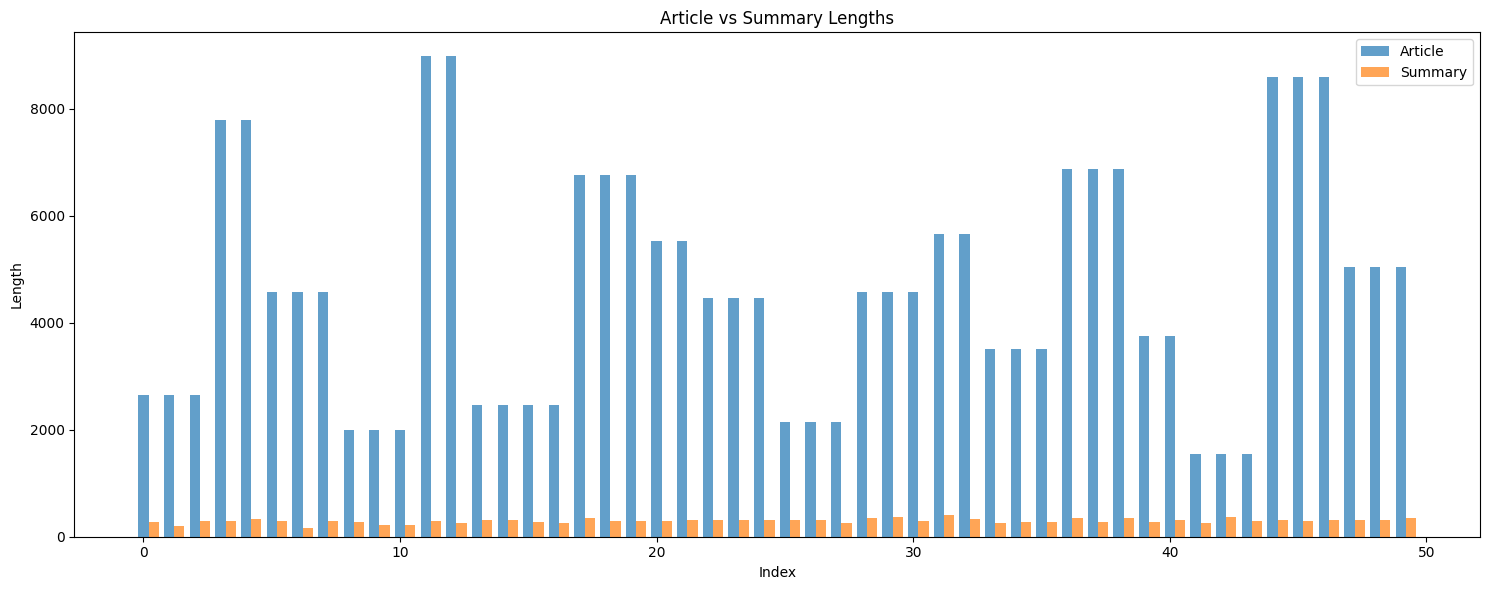

In [4]:
import matplotlib.pyplot as plt

first_x = 50
short_summaries = summaries[:50]

article_len = [len(d["article"]) for d in short_summaries]
summary_len = [len(d["summary"]) for d in short_summaries]
x = range(len(short_summaries))

plt.figure(figsize=(15, 6))
plt.bar(x, article_len, width=0.4, label='Article', alpha=0.7)
plt.bar([i + 0.4 for i in x], summary_len, width=0.4, label='Summary', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Length')
plt.title('Article vs Summary Lengths')
plt.legend()
plt.tight_layout()
plt.show()

The summaries seem pretty consistent in height. Or is that just because the graph is zoomed out?

In [5]:
import numpy as np

# Recalculate to use the whole summaries not just first X
article_len = [len(d["article"]) for d in summaries]
summary_len = [len(d["summary"]) for d in summaries]

print("Article Lengths:")
print(f"  Mean: {np.mean(article_len):.1f}")
print(f"  Std Dev: {np.std(article_len):.1f}")
print(f"  Min: {np.min(article_len)}")
print(f"  Max: {np.max(article_len)}")
print()

print("Summary Lengths:")
print(f"  Mean: {np.mean(summary_len):.1f}")
print(f"  Std Dev: {np.std(summary_len):.1f}")
print(f"  Min: {np.min(summary_len)}")
print(f"  Max: {np.max(summary_len)}")
print()

# coefficient of variation (relation to mean)
cv_article = np.std(article_len) / np.mean(article_len)
cv_summary = np.std(summary_len) / np.mean(summary_len)
print(F"Coefficient: article: {cv_article*100:.2f}%, summary: {cv_summary*100:.2f}%")
print()


# Compression ratios for each pair
ratios = np.array([len(d["summary"]) / len(d["article"]) for d in summaries])
mean_ratio = np.mean(ratios)
std_ratio = np.std(ratios)
print(F"Summaries are {mean_ratio*100:.2f}% the length, with a std dev: {std_ratio*100:.2f}%")
print()

Article Lengths:
  Mean: 4116.9
  Std Dev: 1867.4
  Min: 661
  Max: 8978

Summary Lengths:
  Mean: 291.1
  Std Dev: 44.2
  Min: 144
  Max: 412

Coefficient: article: 45.36%, summary: 15.17%

Summaries are 8.82% the length, with a std dev: 4.92%



Yes! The relation of the std dev to the mean is much lower for the summary. 

How might summary length change with article length?

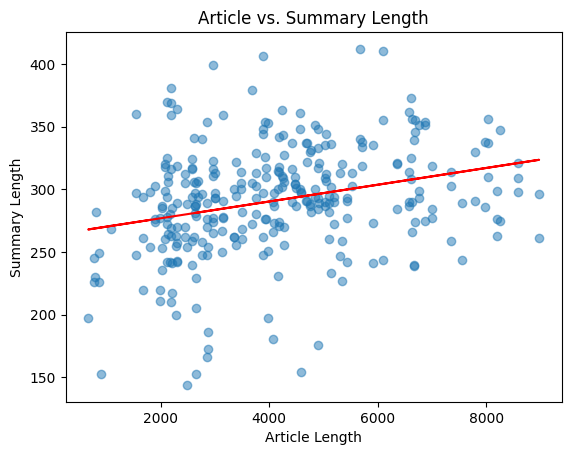

In [6]:
x = np.array(article_len)
y = np.array(summary_len)

m, b = np.polyfit(x, y, 1)  
plt.scatter(x, y, alpha=0.5)
plt.plot(x, m*x + b, color='red', label=f'y = {m:.2f}x + {b:.0f}')

plt.xlabel("Article Length")
plt.ylabel("Summary Length")
plt.title("Article vs. Summary Length")
plt.show()


Hmm.. the linear relationship isn't too bad. Definitely we get a lot of clustering in this range

This does seem to indicate that (at leat in the narrow domain of news summaries) we're likely to see similar lengths of summaries. 

A potential hypothesis is that news articles are constrained by selection pressure towards only communicating X amount of content, which can be expressed in ~300 characters. 

*The actual answer is much less interesting: the paper mentions "we instruct our writers to summarize each article in around 50 words"*

Okay! One final thing. Would be cool to show quantile bands for where the density of these scatter-points are

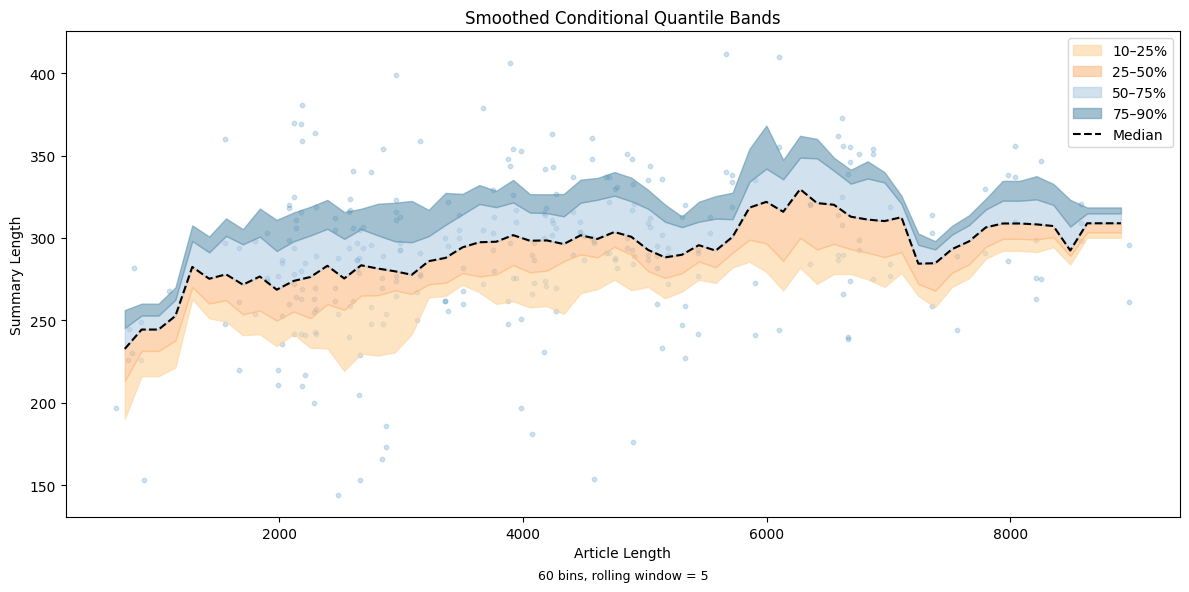

In [19]:
# NEed pandas for rolling avg
import pandas as pd  

x = np.array(article_len)
y = np.array(summary_len)

num_bins = 60
x_bins = np.linspace(min(x), max(x), num_bins + 1)
x_centers = (x_bins[:-1] + x_bins[1:]) / 2

# Collect quantiles per bin
q10, q25, q50, q75, q90 = [], [], [], [], []

for i in range(num_bins):
    mask = (x >= x_bins[i]) & (x < x_bins[i+1])
    if np.any(mask):
        y_vals = y[mask]
        q10.append(np.percentile(y_vals, 10))
        q25.append(np.percentile(y_vals, 25))
        q50.append(np.percentile(y_vals, 50))
        q75.append(np.percentile(y_vals, 75))
        q90.append(np.percentile(y_vals, 90))
    else:
        q10.append(np.nan)
        q25.append(np.nan)
        q50.append(np.nan)
        q75.append(np.nan)
        q90.append(np.nan)

# Smooth with rolling window 
window = 5
q10 = pd.Series(q10).rolling(window, center=True, min_periods=1).mean()
q25 = pd.Series(q25).rolling(window, center=True, min_periods=1).mean()
q50 = pd.Series(q50).rolling(window, center=True, min_periods=1).mean()
q75 = pd.Series(q75).rolling(window, center=True, min_periods=1).mean()
q90 = pd.Series(q90).rolling(window, center=True, min_periods=1).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.2, s=10)

ALPHA = .6
plt.fill_between(x_centers, q10, q25, color='#fdd49e', alpha=ALPHA, label='10–25%')
plt.fill_between(x_centers, q25, q50, color='#fdbb84', alpha=ALPHA, label='25–50%')
plt.fill_between(x_centers, q50, q75, color='#b3cde3', alpha=ALPHA, label='50–75%')
plt.fill_between(x_centers, q75, q90, color='#6497b1', alpha=ALPHA, label='75–90%')
plt.plot(x_centers, q50, color='black', linestyle='--', label='Median')

plt.legend(loc='upper right')
plt.xlabel("Article Length")
plt.ylabel("Summary Length")
plt.title("Smoothed Conditional Quantile Bands")
plt.text(
    0.5, -0.12,
    f"{num_bins} bins, rolling window = {window}",
    ha='center', va='center', transform=plt.gca().transAxes, fontsize=9
)
plt.tight_layout()
plt.show()

